# Assignment 1

Submitted by: Omri Gruman 318965621 and Omer Pessach 318854387

## Introduction

As part of this assignment, we will familiarize ourselves with **PyTorch**, its basic capabilities, and use it in implementing traditional deep learning algorithms.  During this assignment, we will also practice some of the unique machine learning concepts such as cross validation, loss functions, model hyperparameters, and gradient derivation.
We will also learn how to use **numpy** and **sklearn** packages that are most widely used in machine learning.


## Part 1: Working with data in PyTorch


A lot of effort in solving any machine learning problem goes in to preparing the data. Several PyTorch tools are provided to simplify data loading and ultimately make your code more readable. In this part we will use pytorch *Dataset* and *DataLoader* classes which are part of PyTorch's *torch.util.data* package. Being able to use these classes properly is one of the essential skills you should have.

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
% cd /content/drive/MyDrive/Colab Notebooks/MTA/Deep Learning/Assignment 1
from utils import *

/content/drive/MyDrive/Colab Notebooks/MTA/Deep Learning/Assignment 1


### Datasets
<a id=part1_1></a>

The **Dataset** class is an abstraction over a sequence of python objects,
each representing a sample (with or without a label). The main purpose of this function is to load a single (possibly labeled) sample from some source into memory and transform it into some usable representation.

Lets create a demonstration Dataset that returns single color images. It should:
- Return random tensors of size HxWx1.
- Initialize each returned tensor with a same random number from the range [0, 255], we will treat this number as the image's label.
- Label each returned tensor with a the number the tensor if filled.
- Return a total of num_samples labeled images.

__ getitem __ is a build-in function return the sample and its label, using index.

__ len __ is a build-in function return the length of the dataset.

In [ ]:
class SingleColorImageDataset(Dataset):
    """
    A dataset returning single color images of specified dimensions
    """

    def __init__(self, num_samples, W, H):
        """
        :param num_samples: Number of samples (labeled images in the dataset)
        :param num_classes: Number of classes (labels)
        :param W: Image width
        :param H: Image height
        """
        super().__init__()
        self.num_samples = num_samples
        self.image_dim = (1, H, W)
        # TODO: Create a random labels and tensors with dimension of self.image_dim.
        # Fill these tensors with the label and save it as internal variables.
        # ====== YOUR CODE: ======
        self.data = [torch.full(self.image_dim, np.random.random_integers(0, 255)) for _ in range(self.num_samples)]
        # ========================
        
    def __getitem__(self, index):
        # TODO: Create a single color image tensor and return it.
        # ====== YOUR CODE: ======
        sample = self.data[index]
        label = sample[0][0][0]
        # ========================
        return sample, label

    def __len__(self):
        # ====== YOUR CODE: ======
        return self.num_samples
        # ========================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: This function is deprecated. Please call randint(0, 255 + 1) instead


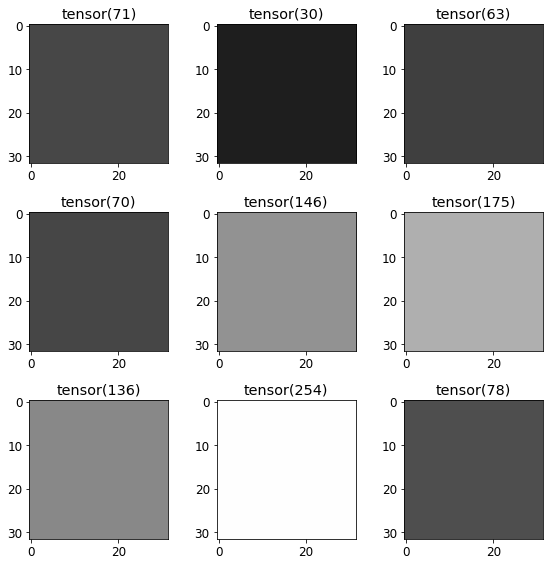

In [ ]:
# Create the dataset
num_samples = 1000
image_size = (32, 32)
dataset = SingleColorImageDataset(num_samples, *image_size)

# You can load individual items from the dataset by indexing
sample, label = dataset[0]
assert label == sample[0][0][0]

plot_dataset( dataset, 9)

### Built-in Datasets and Transforms
<a id=part1_2></a>

Now, after we have created a simple Dataset to see how it works, we will load one of pytorch's built-in datasets - CIFAR-10. This is a famous dataset consisting of 60,000 small 32x32 images classified into 10 classes. You can read more about it [here](https://www.cs.toronto.edu/~kriz/cifar.html).

The torchvision package has built-in Dataset classes that can download the data to a local folder,
load it, transform it using arbitrary transform functions and iterate over the resulting samples.

Run the following code block to download and create a CIFAR-10 Dataset. It won't be downloaded again if already present.

Files already downloaded and verified
Number of samples: 10


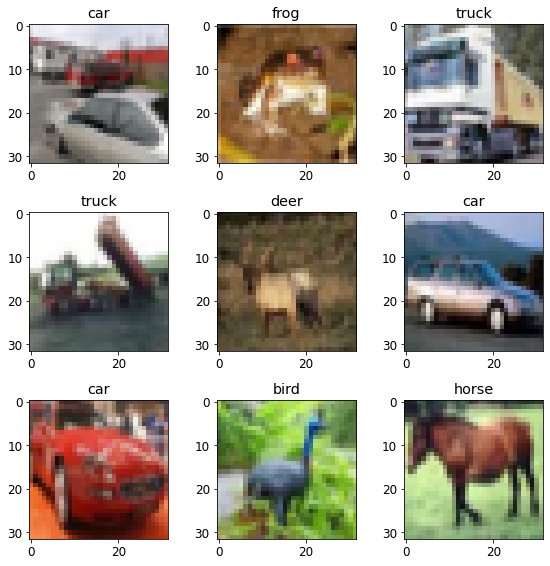

In [ ]:
import torchvision
import torchvision.transforms as tvtf

cfar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cifar10_dataset = torchvision.datasets.CIFAR10(
    root='./data/cifar-10/', download=True, train=True,
    transform=tvtf.ToTensor() # Convert PIL image to pytorch Tensor
)

print('Number of samples:', len(cfar10_classes))

# Plot them with a helper function
plot_dataset( cifar10_dataset, 9, classes = cfar10_classes)

Now, suppose you want to train your model on the first 3 classes from cifar 10, 'plane', 'car', 'bird'. In order to achieve this you will need to wrap the cifar 10 dataset with your own dataset, that will return samples that only from these classes. You may want to use source_dataset.targets to get a list of targets.

In [ ]:
class SubsetDataset(Dataset):
    """
    A dataset that wraps another dataset, returning a subset from it.
    """
    def __init__(self, source_dataset: Dataset, desired_classes: list):
        """
        Create a SubsetDataset from another dataset.
        :param source_dataset: The dataset to take samples from.
        :param desired_classes: List of allowed classes from the original dataset.
        """

        self.source_dataset = source_dataset
        self.desired_classes = desired_classes
        
        # ====== YOUR CODE: ======  
        self.sub_dataset = [
            (image, label) 
            for image, label in self.source_dataset 
            if label in self.desired_classes
        ]
        # ========================

    def __getitem__(self, index):
        # TODO: Return dataset that contains just samples that their class is in desired_classes 

        # ====== YOUR CODE: ======
        sample, label = self.sub_dataset[index]
        
        # ========================
        return sample, label

    def __len__(self):
        # ====== YOUR CODE: ======
        return len(self.sub_dataset)
        # ========================


In [ ]:
subset_len = 5000
subset_offset = 1234
cifar10_train_subset = SubsetDataset(cifar10_dataset, [0,1,2])

# Tests
test.assertEqual(len(cifar10_train_subset), 15000)
classes = []
for _, _class in cifar10_train_subset:
    classes.append(_class)  
test.assertEqual(set(classes), set([0,1,2]))

### DataLoaders and Samplers


We have seen that a Dataset is simply an iterable returning samples by index.
We would like to be able to load batches of data, in order to train our model efficiently.
A DataLoader samples a batch of samples from the dataset according to logic defined by a Sampler object.
The sampler decides how to divide the dataset into batches of N samples. The DataLoader also handles loading samples in parallel to speed up batch creation.

Memory usage is a major motivation here. By combining a DataLoader with a Dataset we are able to easily control memory constraints by simply adjusting the batch size.  This is important since large
datasets may not fit in memory of most machines.
A DataSet can lazily load samples from disk, and the DataLoader can sample random samples from it in parallel, providing us with a straightforward but high-performance way of iterating over random batches from our dataset without needing to hold it all in memory.

Let's create a basic DataLoader for our CIFAR-10 dataset.
Run the follwing code block multiple times and observe that different samples are shown each time in the first few batches.

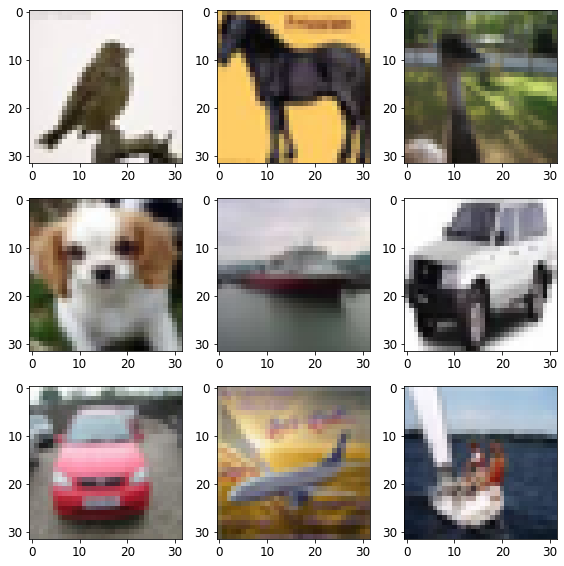

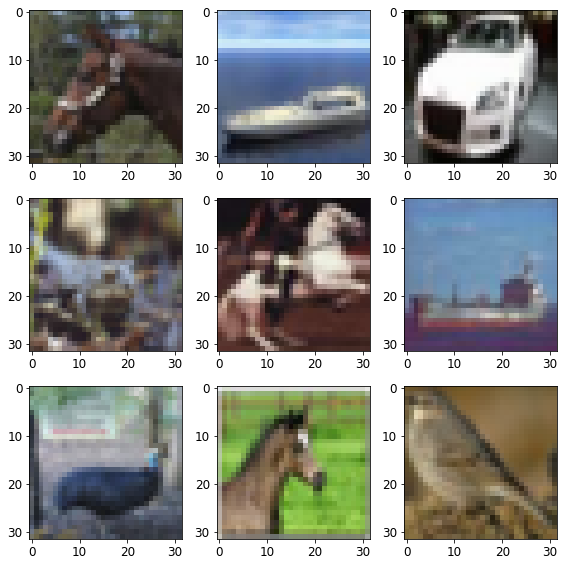

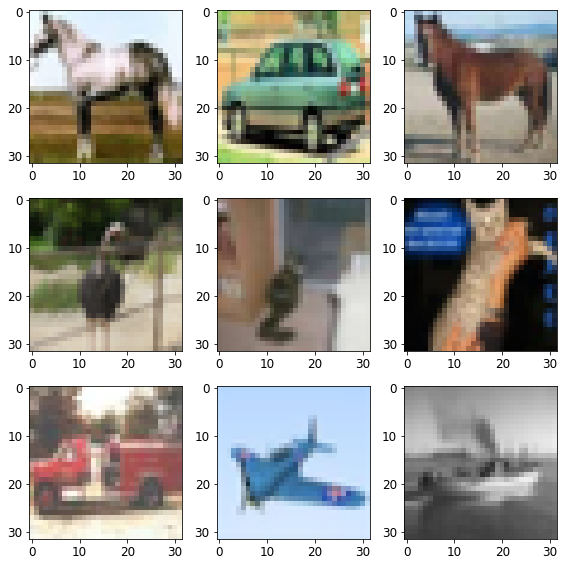

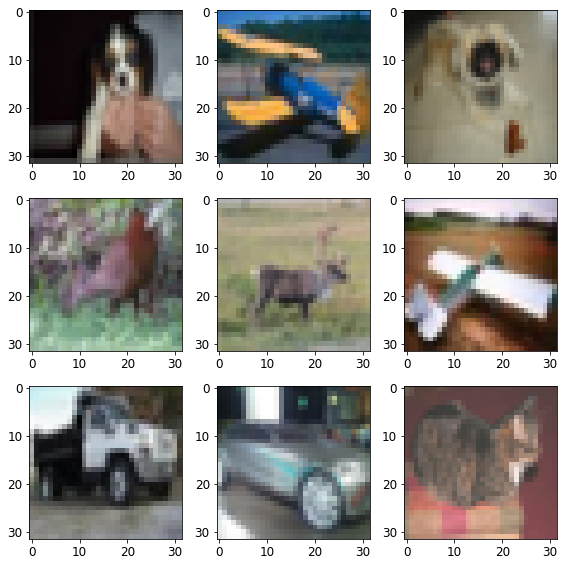

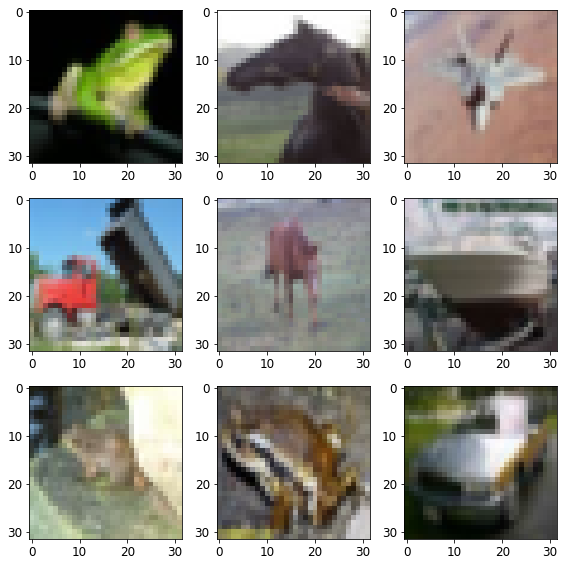

In [ ]:
# Create a simple DataLoader that partitions the data into batches
# of size N=8 in random order, using two background proceses
cifar10_train_dataloader = torch.utils.data.DataLoader(
    cifar10_dataset, batch_size=9, shuffle=True, num_workers=2
)

# Iterate over batches sampled with our DataLoader
num_batches_to_show = 5
for idx, (images, classes) in enumerate(cifar10_train_dataloader):
    plot_tensors_as_images(images, 9)
    if idx >= num_batches_to_show - 1:
        break

### Training, Validation and Test Sets
<a id=part1_4></a>

Now we are ready to prepare our data for training and evaluation.So far we've learnt in class that we will use two dataset, train set and test set, but practicly we will use 3 datasets. The reason is the hyperparameters we need to tune. As you remember, there are several hyperprameters in the model, such as the learning rate or the number of layers, that we need to set. How will we know which value to choose? We will use a seperated set - validation set. You can reed about is also [here](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets). Therefore we want to divide our dataset into 3 partitions - train, validation and test. We will train our model on the training set, choose its hyperparameters using the validation set and evaluate the final model preformance on the test set.

![img](https://www.brainstobytes.com/content/images/2020/01/Sets.png)

Now, you will implement a funciton the split the given dataset into 2 dataloaders, train and validation, using predefined ratio.
You may want to use the sklearn.model_selection.train_test_split function and pytorch DataLoader object

In [ ]:
def create_train_validation_loaders(dataset: Dataset, 
                                         validation_ratio,
                                         batch_size=100):
    """
    Splits a dataset into a train and validation set, returning a
    DataLoader for each.
    :param dataset: The original dataset.
    :param validation_ratio: Ratio (in range 0,1) of the validation set size to
        total dataset size.
    :param batch_size: Batch size the loaders will return from each set.
    :return: A tuple of train, validation and test DataLoader instances.
    """
    if not(0.0 < validation_ratio < 1.0):
        raise ValueError(validation_ratio)
        
        
    # TODO: Create two DataLoader instances, dataloader_train and dataloader_valid.
    # They should together represent a train/validation split of the given
    # dataset. Make sure that:
    # 1. Validation set size is validation_ratio * total number of samples.
    # 2. No sample is in both datasets. You can select samples at random
    #    from the dataset.
    # 3. you use shuffle=True in the train dataloader and shuffle=False in the validation dataloder
    

    # ====== YOUR CODE: ======
    ds_train, ds_valid = train_test_split(dataset, test_size=validation_ratio, random_state=42)
    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    dl_valid = DataLoader(ds_valid, batch_size=batch_size, shuffle=False)
    # ========================

    return dl_train, dl_valid

In [ ]:
validation_ratio = 0.15
dl_train, dl_valid = create_train_validation_loaders(cifar10_dataset,
                                                     validation_ratio = validation_ratio)


train_size = len(dl_train.dataset)
valid_size = len(dl_valid.dataset)
print('Training set size: ', train_size)
print('Validation set size: ', valid_size)

# Tests
test.assertEqual(train_size+valid_size, len(cifar10_dataset), "Incorrect total number of samples")
test.assertEqual(valid_size, validation_ratio * (train_size + valid_size), "Incorrect validation ratio")

Training set size:  42500
Validation set size:  7500
